In [2]:
!pip install openpyxl
!pip install opencv-python

import numpy as np
import pandas as pd 
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
## for VGG pre-trained model it only accepts a 224 x 224 image size
img_size = 224

In [4]:
# open csv file

df_data = pd.read_csv("E:/documents/Mini project/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [8]:
df_data2 = df_data.iloc[:, 1:7]
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [9]:
img_dir = "E:/documents/Mini project/preprocessed_images"

In [10]:
# Left diagnosis with 'cataract' keyword
df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [11]:
## let's place the left cataract data into its own dataframe and print the number of rows
df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [12]:
## let's place the right cataract data into its own dataframe and print the number of rows
df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


In [13]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames

C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\4179546255.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)


0          0_left.jpg
1        103_left.jpg
2        119_left.jpg
3        254_left.jpg
4        294_left.jpg
            ...      
567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
Length: 572, dtype: object

In [15]:
len(df_cat_filenames)

572

(512, 512, 3)
2120_right.jpg


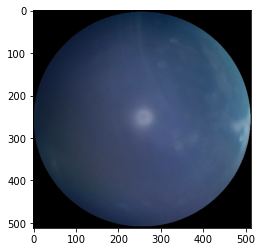

In [16]:
img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

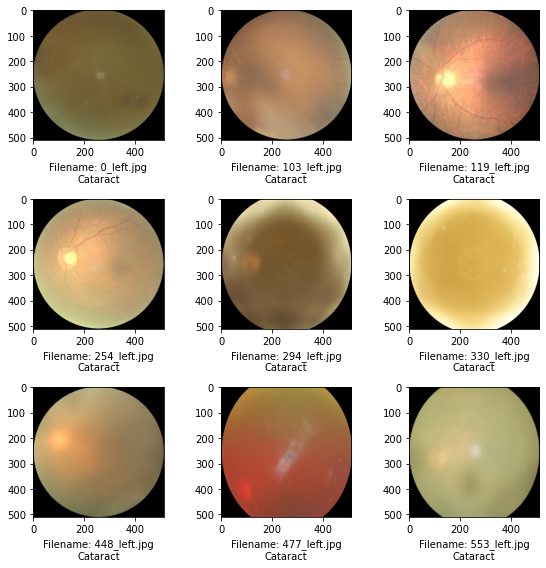

In [17]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout() 


In [20]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [21]:
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


In [22]:
df_norm_filenames = pd.concat((df_left_norm['Left-Fundus'],(df_rt_norm['Right-Fundus'])), axis=0)
df_norm_filenames

1           1_left.jpg
7           8_left.jpg
8           9_left.jpg
12         14_left.jpg
13         15_left.jpg
             ...      
6361    4642_right.jpg
6363    4644_right.jpg
6373    4660_right.jpg
6377    4671_right.jpg
6389    4689_right.jpg
Length: 5590, dtype: object

In [23]:
## let's place the myopia data into its own dataframe and print the number of rows
df_left_myo = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('pathological')]
print(len(df_left_myo))

208


In [24]:
df_rt_myo = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('pathological')]
print(len(df_rt_myo))

225


In [25]:
df_myo_filenames = df_left_myo['Left-Fundus'].append(df_rt_myo['Right-Fundus'], ignore_index=True)
df_myo_filenames

C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\3054610189.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_myo_filenames = df_left_myo['Left-Fundus'].append(df_rt_myo['Right-Fundus'], ignore_index=True)


0         13_left.jpg
1         18_left.jpg
2         35_left.jpg
3        106_left.jpg
4        144_left.jpg
            ...      
428    1666_right.jpg
429    1673_right.jpg
430    1681_right.jpg
431    1686_right.jpg
432    1694_right.jpg
Length: 433, dtype: object

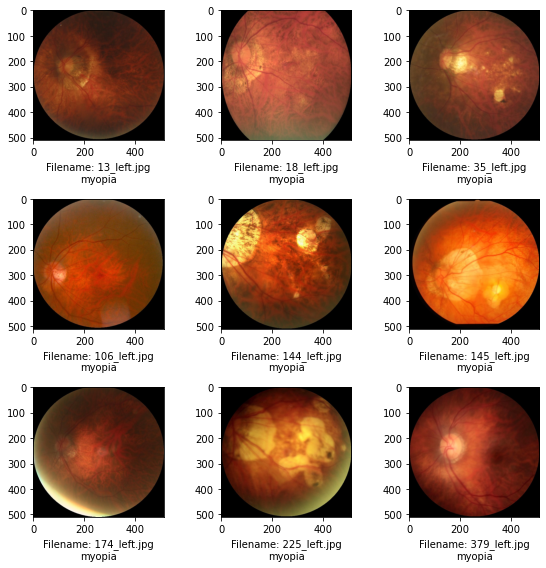

In [26]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_myo_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''myopia'.format(df_myo_filenames[i]))

plt.tight_layout() 

In [67]:
## let's place the hypertensive data into its own dataframe and print the number of rows
df_left_hyp = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('hypertensive')]
print(len(df_left_hyp))

125


In [69]:
df_rt_hyp = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('hypertensive')]
print(len(df_rt_hyp))

130


In [70]:
df_hyp_filenames = df_left_hyp['Left-Fundus'].append(df_rt_hyp['Right-Fundus'], ignore_index=True)
df_hyp_filenames

C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\4258114629.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_hyp_filenames = df_left_hyp['Left-Fundus'].append(df_rt_hyp['Right-Fundus'], ignore_index=True)


0         23_left.jpg
1         28_left.jpg
2         32_left.jpg
3         45_left.jpg
4         62_left.jpg
            ...      
250    4579_right.jpg
251    4581_right.jpg
252    4591_right.jpg
253    4592_right.jpg
254    4784_right.jpg
Length: 255, dtype: object

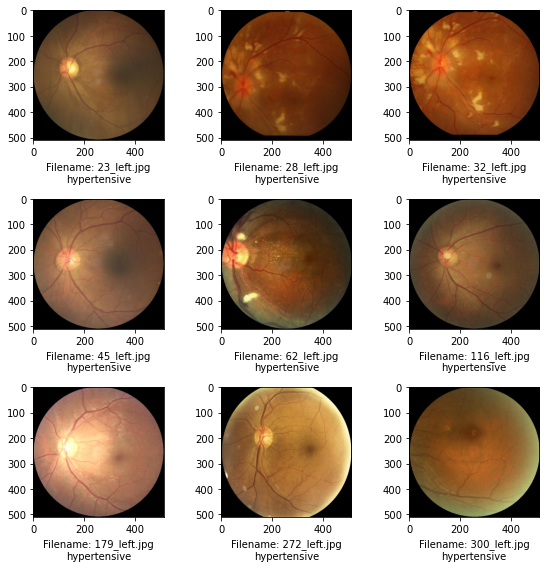

In [71]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_hyp_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''hypertensive'.format(df_hyp_filenames[i]))

plt.tight_layout() 

In [61]:
## let's place the myopia data into its own dataframe and print the number of rows
df_left_gla = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_left_gla))

262


In [62]:
df_rt_gla = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('glaucoma')]
print(len(df_rt_gla))

232


In [63]:
df_gla_filenames = df_left_gla['Left-Fundus'].append(df_rt_gla['Right-Fundus'], ignore_index=True)
df_gla_filenames

C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\801784575.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gla_filenames = df_left_gla['Left-Fundus'].append(df_rt_gla['Right-Fundus'], ignore_index=True)


0        153_left.jpg
1        167_left.jpg
2        583_left.jpg
3       1209_left.jpg
4       1210_left.jpg
            ...      
489    1963_right.jpg
490    1967_right.jpg
491    1977_right.jpg
492    2048_right.jpg
493    2063_right.jpg
Length: 494, dtype: object

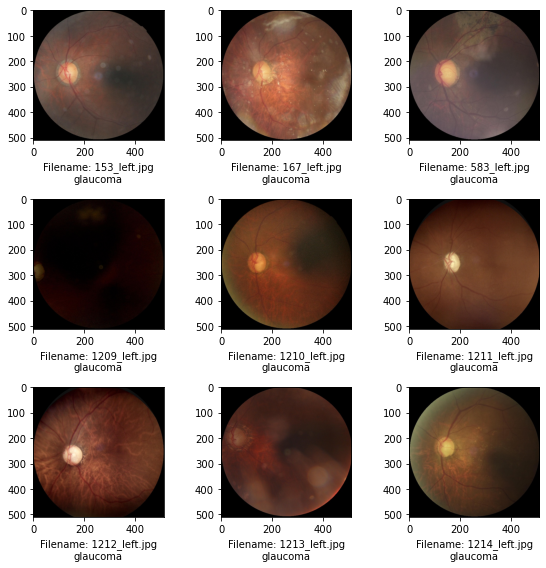

In [64]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_gla_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''glaucoma'.format(df_gla_filenames[i]))

plt.tight_layout() 

In [35]:
## remember we're choosing 255 to equal the number of Hypertensive images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 255)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

5056     2713_left.jpg
3520      376_left.jpg
5592    3297_right.jpg
5161     2826_left.jpg
5224    2897_right.jpg
dtype: object

In [36]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0       2713_left.jpg
1        376_left.jpg
2      3297_right.jpg
3       2826_left.jpg
4      2897_right.jpg
            ...      
428     3384_left.jpg
429    4172_right.jpg
430    2441_right.jpg
431    3423_right.jpg
432    1280_right.jpg
Length: 433, dtype: object

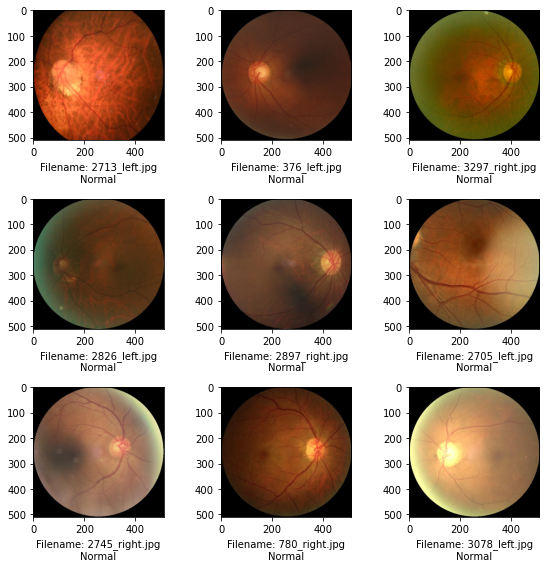

In [37]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [38]:
## remember we're choosing 255 to equal the number of hypertension images we pulled

df_cat_filenames_random = df_cat_filenames.sample(n = 255)
df_cat_filenames_random.head()

## looks like the index is out of order now that we got all the randos

511    2165_right.jpg
425    2236_right.jpg
296     188_right.jpg
545    2210_right.jpg
380    2176_right.jpg
dtype: object

In [39]:
## we will reset the index as well
df_cat_filenames_random = df_cat_filenames_random.reset_index(drop=True)
df_cat_filenames_random

0      2165_right.jpg
1      2236_right.jpg
2       188_right.jpg
3      2210_right.jpg
4      2176_right.jpg
            ...      
428      24_right.jpg
429     726_right.jpg
430     2203_left.jpg
431     2240_left.jpg
432      24_right.jpg
Length: 433, dtype: object

In [40]:
## remember we're choosing 255 to equal the number of hypertension images we pulled

df_myo_filenames_random = df_myo_filenames.sample(n = 255)
df_myo_filenames_random.head()

## looks like the index is out of order now that we got all the randos

384    1561_right.jpg
257    1550_right.jpg
13       741_left.jpg
27      1532_left.jpg
293    1597_right.jpg
dtype: object

In [41]:
## we will reset the index as well
df_myo_filenames_random = df_myo_filenames_random.reset_index(drop=True)
df_myo_filenames_random

0      1561_right.jpg
1      1550_right.jpg
2        741_left.jpg
3       1532_left.jpg
4      1597_right.jpg
            ...      
428    1567_right.jpg
429     1588_left.jpg
430    1578_right.jpg
431    1563_right.jpg
432    1681_right.jpg
Length: 433, dtype: object

In [74]:
df_hyp_filenames_random = df_hyp_filenames
df_hyp_filenames_random.head()

## looks like the index is out of order now that we got all the randos

74       345_left.jpg
70       272_left.jpg
199     272_right.jpg
108     1867_left.jpg
241    3951_right.jpg
dtype: object

In [75]:
## we will reset the index as well
df_hyp_filenames_random = df_hyp_filenames_random.reset_index(drop=True)
df_hyp_filenames_random

0        345_left.jpg
1        272_left.jpg
2       272_right.jpg
3       1867_left.jpg
4      3951_right.jpg
            ...      
250      754_left.jpg
251    4591_right.jpg
252    4562_right.jpg
253     968_right.jpg
254     723_right.jpg
Length: 255, dtype: object

In [44]:
df_cat_filenames_random = pd.DataFrame(df_cat_filenames, columns = ["filename"])

# add a new column of '1' to the dataframe
df_cat_filenames_random["label"] = "cataract"

df_cat_filenames_random.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [65]:
df_gla_filenames_random = pd.DataFrame(df_gla_filenames, columns = ["filename"])

# add a new column of '1' to the dataframe
df_gla_filenames_random["label"] = "glaucoma"

df_gla_filenames_random.head()

,filename,label
0,153_left.jpg,glaucoma
1,167_left.jpg,glaucoma
2,583_left.jpg,glaucoma
3,1209_left.jpg,glaucoma
4,1210_left.jpg,glaucoma


In [45]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2713_left.jpg,normal
1,376_left.jpg,normal
2,3297_right.jpg,normal
3,2826_left.jpg,normal
4,2897_right.jpg,normal


In [46]:
df_myo_filenames_random = pd.DataFrame(df_myo_filenames_random, columns = ["filename"])

# add a new column of '1' to the dataframe
df_myo_filenames_random["label"] = "myopia"

df_myo_filenames_random.head()

,filename,label
0,1561_right.jpg,myopia
1,1550_right.jpg,myopia
2,741_left.jpg,myopia
3,1532_left.jpg,myopia
4,1597_right.jpg,myopia


In [77]:
df_hyp_filenames_random = pd.DataFrame(df_hyp_filenames, columns = ["filename"])

# add a new column of '1' to the dataframe
df_hyp_filenames_random["label"] = "hypertension"

df_hyp_filenames_random.head()

,filename,label
0,23_left.jpg,hypertension
1,28_left.jpg,hypertension
2,32_left.jpg,hypertension
3,45_left.jpg,hypertension
4,62_left.jpg,hypertension


In [79]:
df_combined = df_cat_filenames_random.append(df_norm_filenames_random, ignore_index=True)
df_combined = df_combined.append(df_gla_filenames_random, ignore_index=True)
df_combined = df_combined.append(df_hyp_filenames_random, ignore_index=True)
df_combined = df_combined.append(df_myo_filenames_random, ignore_index=True)
df_combined

C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\3302944069.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_cat_filenames_random.append(df_norm_filenames_random, ignore_index=True)
C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\3302944069.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df_gla_filenames_random, ignore_index=True)
C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\3302944069.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df_hyp_filenames_random, ignore_index=True)
C:\Users\Ajay\AppData\Local\Temp\ipykernel_13912\3302944069.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
2182,1567_right.jpg,myopia
2183,1588_left.jpg,myopia
2184,1578_right.jpg,myopia
2185,1563_right.jpg,myopia


In [80]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,323_left.jpg,hypertension
1,809_left.jpg,cataract
2,722_right.jpg,myopia
3,2122_left.jpg,cataract
4,3260_left.jpg,normal
...,...,...
2182,2246_left.jpg,cataract
2183,3051_right.jpg,normal
2184,2097_right.jpg,cataract
2185,2114_left.jpg,cataract


In [81]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

2187
1750
437


In [82]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [83]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [84]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

D:\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 1400 validated image filenames belonging to 5 classes.
Found 349 validated image filenames belonging to 5 classes.
Found 437 validated image filenames belonging to 5 classes.


D:\anaconda3\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [85]:
train_image_data, train_labels = train_generator.next()
train_image_data.shape

(32, 224, 224, 3)

In [86]:
train_labels[0]

array([0., 0., 0., 0., 1.], dtype=float32)

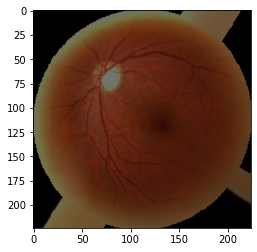

In [87]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

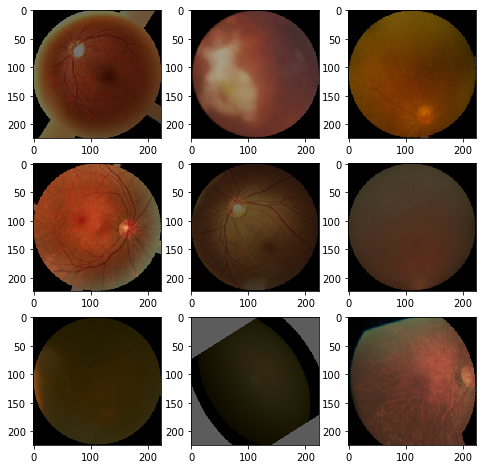

In [88]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

In [89]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 5 outputs
predictions = keras.layers.Dense(5, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [90]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq='epoch')

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [91]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

43 10


In [110]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=False,
                        callbacks=[checkpoint,early])

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 0.9265 - accuracy: 0.3393
Epoch 1: val_accuracy improved from -inf to 0.43403, saving model to vgg16_1.h5
37/37 [==============================] - 170s 5s/step - loss: 0.9265 - accuracy: 0.3393 - val_loss: 0.5539 - val_accuracy: 0.4340
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.4756
Epoch 2: val_accuracy improved from 0.43403 to 0.64583, saving model to vgg16_1.h5
37/37 [==============================] - 171s 5s/step - loss: 0.5112 - accuracy: 0.4756 - val_loss: 0.4178 - val_accuracy: 0.6458
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.5758
Epoch 3: val_accuracy did not improve from 0.64583
37/37 [==============================] - 173s 5s/step - loss: 0.4347 - accuracy: 0.5758 - val_loss: 0.3981 - val_accuracy: 0.6181
Epoch 4/30
37/37 [==============================] - ETA: 0s - loss: 0.4030 - accuracy: 0.5904
Epoch 4: val_accurac

In [113]:
from keras.models import load_model
model = load_model('./vgg16_1.h5')

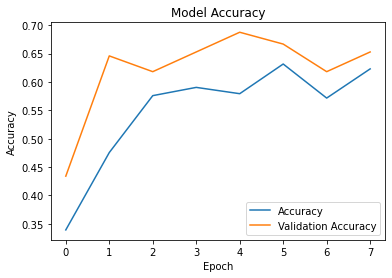

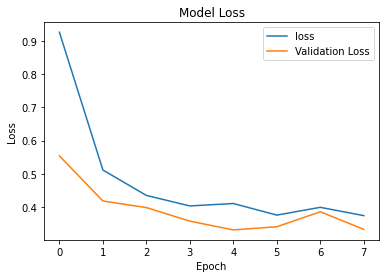

In [112]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [114]:
test_generator.reset()

In [115]:
pred = model.predict(test_generator,verbose=1,steps=test_generator.samples/batch_size)

13/13 [==============================] - 45s 3s/step


In [116]:
## let's get the first 10 rows
print(pred[0:10])

[[9.9538225e-01 1.1884122e-03 1.4914857e-03 1.1059522e-04 1.8272193e-03]
 [5.0563272e-04 1.2349797e-01 2.7778506e-01 1.1679137e-02 5.8653224e-01]
 [3.8263991e-02 1.3603473e-01 6.2318015e-01 2.8415961e-02 1.7410518e-01]
 [9.9575716e-01 5.6102889e-04 2.1491735e-03 6.5305336e-05 1.4674634e-03]
 [4.1401279e-05 5.3086419e-02 1.7882232e-01 2.0030947e-01 5.6774038e-01]
 [9.9166167e-01 1.3342731e-03 3.3307797e-03 2.9623791e-04 3.3768849e-03]
 [2.2056950e-03 2.3976001e-03 2.6287228e-02 9.1670954e-01 5.2400038e-02]
 [5.4463925e-04 5.3170673e-03 8.7994683e-01 1.0967430e-02 1.0322400e-01]
 [9.9870241e-01 2.0056211e-04 4.5743684e-04 4.5816592e-05 5.9382297e-04]
 [4.8749134e-05 1.6137069e-02 1.9972348e-03 9.8048741e-01 1.3295142e-03]]


In [117]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[0 4 2 0 4 0 3 2 0 3]


In [118]:
print(len(predicted_class_idx))

437


In [119]:
model.evaluate(test_generator,use_multiprocessing=False,workers=10)

14/14 [==============================] - 45s 3s/step - loss: 0.3204 - accuracy: 0.6545


[0.3204367458820343, 0.6544622182846069]

In [120]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('glaucoma', 1), ('hypertension', 2), ('myopia', 3), ('normal', 4)])

In [121]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [122]:
pred_labels[1:10]

['normal',
 'hypertension',
 'cataract',
 'normal',
 'cataract',
 'myopia',
 'hypertension',
 'cataract',
 'myopia']

In [123]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,809_left.jpg,cataract
1,3260_left.jpg,normal
2,1352_right.jpg,hypertension
3,2219_right.jpg,cataract
4,3274_left.jpg,normal


In [124]:
prediction_df.iloc[35]

Filename      1545_left.jpg
Prediction           myopia
Name: 35, dtype: object

In [125]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

1545_left.jpg
3


In [126]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'glaucoma': 1, 'hypertension': 2, 'myopia': 3, 'normal': 4}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   cataract    cataract      809_left.jpg
 Correct   normal    normal      3260_left.jpg
 Wrong     hypertension    glaucoma      1352_right.jpg
 Correct   cataract    cataract      2219_right.jpg
 Correct   normal    normal      3274_left.jpg
 Correct   cataract    cataract      1484_left.jpg
 Correct   myopia    myopia      1565_left.jpg
 Wrong     hypertension    normal      2415_right.jpg
 Correct   cataract    cataract      2104_right.jpg
 Wrong     myopia    glaucoma      1289_right.jpg
 Correct   myopia    myopia      1520_right.jpg
 Correct   glaucoma    glaucoma      2063_left.jpg
 Wrong     cataract    glaucoma      1251_right.jpg
 Correct   cataract    cataract      2262_left.jpg
 Wrong     hypertension    glaucoma      2030_left.jpg
 Correct   hypertension    hypertension      1048_right.jpg
 Wrong     hypertension    glaucoma      1344_right

 Wrong     normal    glaucoma      1227_right.jpg
 Correct   hypertension    hypertension      272_left.jpg
 Correct   hypertension    hypertension      818_left.jpg
 Wrong     hypertension    normal      2828_right.jpg
 Correct   cataract    cataract      2163_left.jpg
 Wrong     hypertension    glaucoma      1288_right.jpg
 Correct   normal    normal      2748_left.jpg
 Correct   myopia    myopia      1681_right.jpg
 Wrong     hypertension    glaucoma      1265_right.jpg
 Correct   myopia    myopia      1588_left.jpg
 Correct   myopia    myopia      1579_right.jpg
 Correct   hypertension    hypertension      723_left.jpg
 Wrong     cataract    glaucoma      1215_left.jpg
 Correct   cataract    cataract      750_left.jpg
 Correct   cataract    cataract      2220_right.jpg
 Correct   myopia    myopia      1561_left.jpg
 Wrong     hypertension    normal      884_right.jpg
 Wrong     hypertension    cataract      1968_left.jpg
 Wrong     glaucoma    normal      3301_right.jpg
 Correct   

In [127]:
test_image_data, test_labels = test_generator.next()

In [128]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 5)


In [129]:
x_test, y_test = test_generator.next()


In [130]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 [==============================] - 3s 3s/step - loss: 0.2486 - accuracy: 0.7500
loss: 0.24859480559825897
Accuracy: 0.75


In [131]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

809_left.jpg
0


'cataract'

In [132]:
test_labels[5]

array([1., 0., 0., 0., 0.], dtype=float32)

In [133]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([0, 4, 1, 0, 4, 0, 3, 4, 0, 1, 3, 1, 1, 0, 1, 2, 1, 2, 1, 3, 0, 3,
       2, 0, 4, 4, 0, 4, 4, 2, 1, 1], dtype=int64)

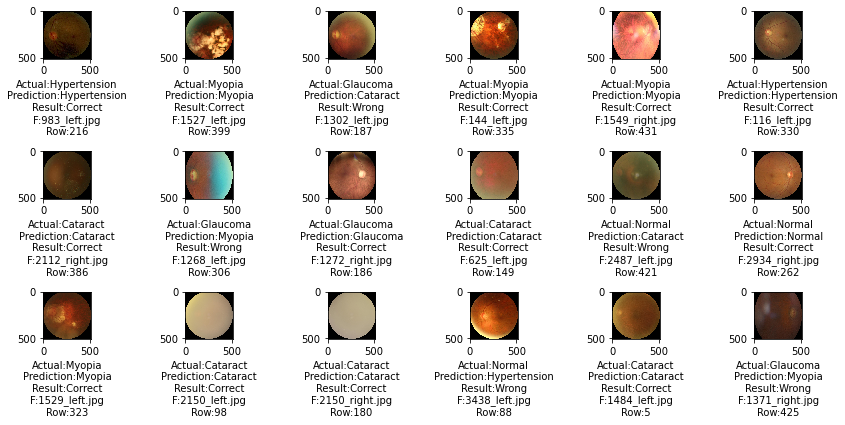

In [134]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]
              
    if category== 0:
        label = "Cataract"
    elif category== 1:
        label = "Glaucoma"
    elif category== 2:
        label = "Hypertension"
    elif category== 3:
        label = "Myopia"
    else:
        label = "Normal"
        
    if pred_category== "normal":
        pred_label = "Normal"
    elif pred_category== "cataract":
        pred_label = "Cataract"
    elif pred_category== "hypertension":
        pred_label = "Hypertension"
    elif pred_category== "glaucoma":
        pred_label = "Glaucoma"
    else:
        pred_label = "Myopia"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout() 

In [136]:
print('Classification Report')
target_names = ['Cataract','Glaucoma','hypertension','myopia','Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

    Cataract       0.73      0.97      0.84       116
    Glaucoma       0.82      0.28      0.42        95
hypertension       0.36      0.77      0.49        53
      myopia       0.84      0.94      0.89        85
      Normal       0.62      0.28      0.39        88

    accuracy                           0.65       437
   macro avg       0.68      0.65      0.61       437
weighted avg       0.71      0.65      0.62       437



In [137]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[113,   0,   2,   0,   1],
       [ 25,  27,  29,   6,   8],
       [  4,   0,  41,   3,   5],
       [  1,   0,   3,  80,   1],
       [ 11,   6,  40,   6,  25]], dtype=int64)

In [138]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [139]:
cm_plot_labels = ['Cataract','Glaucoma','hypertension','myopia','Normal']

Confusion matrix, without normalization
[[113   0   2   0   1]
 [ 25  27  29   6   8]
 [  4   0  41   3   5]
 [  1   0   3  80   1]
 [ 11   6  40   6  25]]


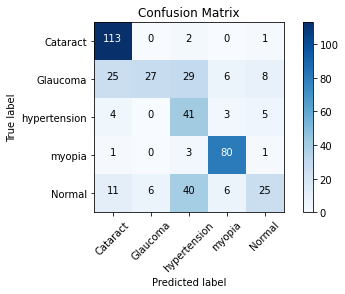

In [140]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')